Wikipedia says:  
In a quantitative decision-analysis model:
* uncertainties are represented through probabilities -- specifically, subjective probabilities.
* The decision maker's attitude to risk is represented by utility functions, and 
* the attitude to trade-offs between conflicting objectives can be expressed using multi-attribute value functions or multi-attribute utility functions (if there is risk involved). (In some cases, utility functions can be replaced by the probability of achieving an uncertain aspiration level or "target".)

Based on the axioms of decision analysis, the best decision to choose is the one whose consequences have the maximum expected utility (or that maximizes the probability of achieving the uncertain aspiration level).

# TL;DR
How you shift your guesses to maximise your chances of winning, at the expense of reducing your risk, and your expected gains based on:
* The historical showcase prices
* Your guess for the current showcase
* Your ability to guess right
* How well your opponent performed in the past.
* How close you get to the showcase price

We will call this shift the Bayes strategy throughout the notebook.

# Procedure:
Let $\boldsymbol{X}$ be a random variable that represents the value of the current showcase price. We can estimate $\boldsymbol{X}$ by:

$$\boldsymbol{X}\sim \text{argmax}_a\text{ }L(a)$$

which means that we are seeking the price $a$ that maximizes the objective function $L$, that is defined as follows:  

$$L = \sum_{j=1}\mathbf{b}\cdot\mathbf{C}$$

Which is the sum over rows of the dot product between the probability of the current showcase and the matrix of all possible outcomes, more specifically:
* $\mathbf{b} = P(h|e)$, a bayesian estimation of the current price $a$ based on the ground truth of historical prices $h$ given our guess for the current showcase and our ability to guess right $e$
* $\mathbf{C}$, represents our chances of winning depending how off we fall from the price and how well we perform with respect to our opponent for each possible price in the $a$ range of prices

Let's start first with the frog.

## Chances matrix
$\mathbf{C}$ is the heart of decision theory that states that for any decision problem you have there are:
* a set of states that do not depend on you, and 
* a set of actions that you can perform

Then, for every pair state-action you assign a value. The moment you do this you have a decision preference that follows the [von Neumann-Morgenstern](https://en.wikipedia.org/wiki/Von_Neumann%E2%80%93Morgenstern_utility_theorem) rules

In this case the states are the possible prices of the showcase and the actions are the bids. The value is generated as follows:

$$
f(P_i, P_j) =
  \begin{cases}
    0          & \quad \text{if } P_i - P_j > 0 \text{ (you overbid)}\\
    p_b + p_o  & \quad \text{otherwise }
  \end{cases}
$$

Where:

$p_b$ is the probability of your opponent underbidding by more than you.  
$p_o$ is the probability of your opponent overbidding.  
We calculate these based on previous results.  
This is a small sample of what the matrix could look like:
```
p = {1, 2, 3}  # The range of possible prices

      pi - pj      f(pi, pj)
    1   2   3
1   0   1   2     .5   0   0
2  -1   0   1  => .2  .5   0
3  -2  -1   0     .1  .2  .2
```
Where the rows represent the possible prices (states) and the columns represent possible bids (actions)

## Bayes estimator
Of course not all the prices have the same probability to appear, so we need to come up with an estimate of this probability. To do so we start off some ground truth that are previous prices:  
$h = \text{kde(historical\_prices)}$

Then, we have the likelihood that represents our ability of guessing right defined as:  
$e = \mathcal{N}(\mu=g, \sigma=std(error))$

Where $g$ is our current guess and $std(error)$ is the standard deviation of our previous guesses. This assumes that over the long haul we always guess right, that is, if some price is 20k and we guess 22k, then there will be some other time when the price being again 20k (for simplicity) we guess 18k.

## Sum over rows
So we have a matrix with chances of winning depending the showcase price, the amount we bid and a vector that tells us the probability of some price to appear. Thus, we can multiply each price by its probability to appear and then sum over rows to get the chances for each bid (remember that columns represent bids). 

With this we are left with a probability distribution for each bid from where we are looking for the $\mathrm{argmax}$, that is, the bid that maximises our options of winning.

## Maximizing the expected gains
Above approach is conservative meaning that the objective function will reduce our optimal bid to avoid overbidding, but we can increase a bit the expected gains at the expense of being riskier because if we underbid within \$250, we will win both showcases. So in the chances of winning we can do the following:

$$
f(P_i, P_j) =
  \begin{cases}
    0          & \quad \text{if } P_i - P_j > 0 \text{ (you overbid)}\\
    k\cdot(p_b + p_o)  & \quad \text{if }250 < P_i - P_j < 0 \text{ (winning both)}\\
    p_b + p_o  & \quad \text{otherwise}
  \end{cases}
$$

Where $k$ is a risk factor that we can adjust.

# Crunching the numbers
Let's translate all above to the algorithm. To start with, we import the data.

## Import historical data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt

# Import the data
def read_data(filename):
    """Read the showcase price data."""
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    df = df.dropna().transpose()
    df = df.rename(columns={
        'Showcase 1': 'showcase_1',
        'Showcase 2': 'showcase_2',
        'Bid 1': 'bid_1',
        'Bid 2': 'bid_2',
        'Difference 1': 'diff_1',
        'Difference 2': 'diff_2',
    })
    # it turns out that diffs are swapped
    df.loc[:, 'diff_1'] = -df.diff_1
    df.loc[:, 'diff_2'] = -df.diff_2
    return df

df2011 = read_data('data/showcases.2011.csv')
df2012 = read_data('data/showcases.2012.csv')
df = pd.concat([df2011, df2012], ignore_index=True)
df.sample(3)

,showcase_1,showcase_2,bid_1,bid_2,diff_1,diff_2
127,26732.0,28480.0,18000.0,21000.0,-8732.0,-7480.0
171,25366.0,26525.0,21000.0,24050.0,-4366.0,-2475.0
181,27690.0,41765.0,23000.0,36000.0,-4690.0,-5765.0


## Create the bayesian estimator
**Exercise:**
You might want to reproduce the bayes table of the estimations
* build a bayes table with the priors
* calculate likes for 23k and 38k
* calculate posteriors
* plot the results



The expected value with historical data is 30299.0
The expected value after adding our observations is 26192.0


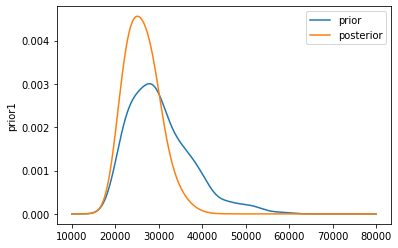

In [2]:
# buid a bayes table with all the data
# min showcase ever 18.3k, max 71.6k
# let's give some decent resolution to compute the maximization of the gains
price_range = np.linspace(10_000, 80_000, 1401)  
bt = pd.DataFrame({
    "prior1": gaussian_kde(df.showcase_1).pdf(price_range),
    "prior2": gaussian_kde(df.showcase_2).pdf(price_range),
}, index=price_range)

# Calculate likes, this measures how wrong we were in the past.
bt["like1"] = norm(23_000, df.diff_1.std()).pdf(price_range)
bt["like2"] = norm(38_000, df.diff_2.std()).pdf(price_range)

bt["post1"] = bt.prior1 * bt.like1
bt["post2"] = bt.prior2 * bt.like2

# Normalize data
def normalize_column(df, col_name):
    df[col_name] /= df[col_name].sum()

[normalize_column(bt, col) for col in (
    "prior1", "prior2", "like1", "like2", "post1", "post2")
]

# Plot distributions
sns.lineplot(x=bt.index, y=bt.prior1, label="prior")
sns.lineplot(x=bt.index, y=bt.post1, label="posterior")

# Print some data
prior_expected_price = np.sum(bt.prior1 * bt.index).round(0)
posterior_expected_price = np.sum(bt.post1 * bt.index).round(0)
print(f"The expected value with historical data is {prior_expected_price}")
print(f"The expected value after adding our observations is {posterior_expected_price}")

## Create the chances matrix

In [3]:
def get_chances_of_winning(off_range, diff_series, k=1):
    """
    Compute the probability of winning depending on your opponent performance.

    Args:
        * off_range: how off you fall from the showcase price.
        * diff_series: how well your opponent performs
        * k: risk factor to maximise the gains
    """

    # TODO: all this can be made without iterating over rows in the off_ranges. Figure out how
    chances = off_range.copy()

    # if you overbid, you loose
    chances[off_range > 0] = 0

    # if your opponent overbids you win
    opponent_overbids = (diff_series > 0).mean()

    # Alternatively if you underbid by less than your opponent you win
    vx, vy = np.meshgrid(diff_series, off_range)
    opponent_underbids_by_more = (vx < vy).mean(axis=1)

    # Get the sum of above
    chances_under_0 = opponent_underbids_by_more + opponent_overbids

    # Increase close to 0 bids by risk factor
    chances_under_0[(-250 <= off_range) & (off_range <= 0)] *= k

    # Add to the chances chances that are not 0 (as they were assigned in the first step)
    chances[off_range <= 0] = chances_under_0[off_range <= 0]

    return chances

# we need to create a off range centered at current price for each price in the
# price range.
_, vy = np.meshgrid(price_range, price_range)  # broadcast price range onto a new axis
off_ranges = price_range - vy

# slightly faster than the equivalent for loop but more clean. This roughly means: compute
# the chances of winning over rows in the off_ranges array.
chances_matrix_k1 = np.apply_along_axis(
    get_chances_of_winning, 1, off_ranges, diff_series=df.diff_2
)
chances_matrix_k4 = np.apply_along_axis(
    get_chances_of_winning, 1, off_ranges, diff_series=df.diff_2, k=4
)

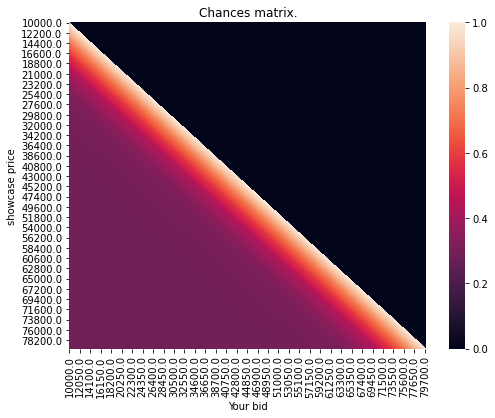

In [4]:
df1 = pd.DataFrame(chances_matrix_k1) / chances_matrix_k1.max()
df1.index = price_range
df1 = df1.rename(columns={n: pr for n, pr in enumerate(price_range)})
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df1, ax=ax);
ax.set_title("Chances matrix.")
ax.set_xlabel("Your bid"), ax.set_ylabel("showcase price");

## Sum over rows and plot the results

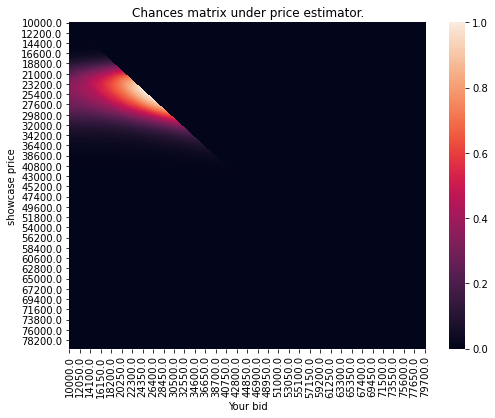

In [5]:
k1 = (chances_matrix_k1.T * bt.post1.values).T
df1 = pd.DataFrame(k1) / k1.max()
df1.index = price_range
df1 = df1.rename(columns={n: pr for n, pr in enumerate(price_range)})
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df1, ax=ax);
ax.set_title("Chances matrix under price estimator.")
ax.set_xlabel("Your bid"), ax.set_ylabel("showcase price");

The optimal bid without risk is 20550.0
The optimal risk=4 is 21350.0


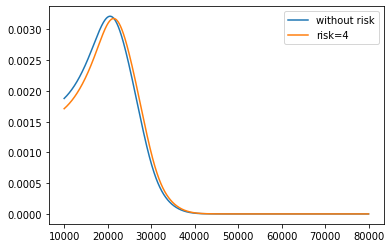

In [6]:
k1 = k1.sum(axis=0)
k1 /= k1.sum()
sns.lineplot(x=price_range, y=k1, label='without risk');

k4 = (chances_matrix_k4.T * bt.post1.values).T.sum(axis=0)
k4 /= k4.sum()
sns.lineplot(x=price_range, y=k4, label='risk=4');
opt1, opt4 = [pd.Series(array, index=price_range).idxmax() for array in (k1, k4)]
print(f"The optimal bid without risk is {opt1}")
print(f"The optimal risk=4 is {opt4}")

# Gaussian KDE playground

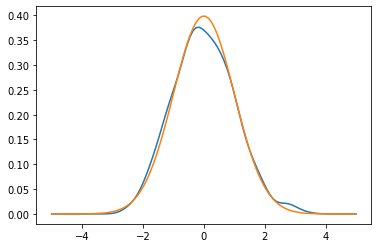

In [7]:
sample = np.random.normal(size=500)
x_range = np.linspace(-5, 5, 100)

kde = gaussian_kde(sample)
y = kde(x_range)

n_dist = norm.pdf(x_range)

sns.lineplot(x=x_range, y=y);
sns.lineplot(x=x_range, y=n_dist);


# Performance strategy
By means of the `bayes_predictions.py` script we can compute what happens when both players play this same strategy for 4 historical games (initially we computed for 50, 100, 200 & 300 games but it wasn't very relevant)

It could be interesting to know:
* How better is the bayes strategy with respect to the non-bayes strategy?
* If we have a guessing accuracy over the long run slightly higher than the real price, does the bayes strategy help us?

## Original guesses vs bayesian guesses

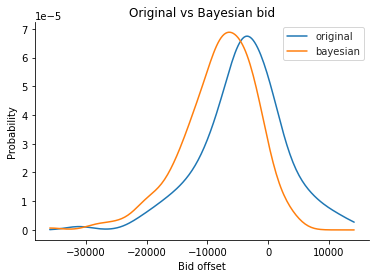

In [8]:
k4 = pd.read_csv("09-outcomes/showcases-4.csv", index_col=0)

# Visualize how different are the original guesses with respect to the bayes approach
p1_diffs = k4[["diff_1", "estimated_diff1"]]
diff_range = np.linspace(p1_diffs.min().min(), p1_diffs.max().max(), 200)
kde0, kde1 = [gaussian_kde(d)(diff_range) for d in (k4.diff_1, k4.estimated_diff1)]

_, ax = plt.subplots()
sns.set_style("whitegrid")
sns.lineplot(x=diff_range, y=kde0, label="original")
sns.lineplot(x=diff_range, y=kde1, label="bayesian")
sns.despine()
ax.set_xlabel("Bid offset"), ax.set_ylabel("Probability")
ax.set_title("Original vs Bayesian bid");

In [9]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, Span, Label
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

## Original performance vs bayesian performance

### History 4 analysis
* With the original approaches p1 performs slightly better 51.2%. But when both play bayes p2 manages to outperform (by very few) 50.2%. This could be an statistical fact meaning that since both are playing the same strategy they are approaching a nash equilibrium that eventually 
* We reach the minimun no winner when both play the bayes strategy.
* p1 performs slightly better when he plays bayes and p2 follows the original strategy. Mostly at the expense of reducing the no winner (.07 -> .019) but also a bit at the expense of reducing the chances of p2 (.45->.44)
* p2 does not increase its performance as much as p1 when he plays the bayes strategy mainly because it's not able to reduce the no_winner (.07->.031) as the amount it takes from p1 is the same amount p1 takes from p1 in the reverse situation.


In [10]:
df = pd.read_csv("09-outcomes/showcases-4.csv", index_col=0)

def determine_winner(diff1, diff2):
    """Determine the winner for two given diffs from the original price."""
    winner_array = np.zeros(diff1.shape)  # Where zero means no winner
    p1_overbids = diff1 > 0
    p2_overbids = diff2 > 0
    p1_gt_p2 = diff1 > diff2
    p1_wins = ((p1_gt_p2 | p2_overbids) & ~p1_overbids)
    p2_wins = ((~p1_gt_p2 | p1_overbids) & ~p2_overbids)
    winner_array[p1_wins] = 1
    winner_array[p2_wins] = 2
    return winner_array.astype(int).astype(str)

def add_strategies_to_df(df):
    df['original'] = determine_winner(df.diff_1, df.diff_2)
    df['p1_bayes'] = determine_winner(df.estimated_diff1, df.diff_2)
    df['p2_bayes'] = determine_winner(df.diff_1, df.estimated_diff2)
    df['both_bayes'] = determine_winner(df.estimated_diff1, df.estimated_diff2)
    return df

def get_improvement(df):
    df = add_strategies_to_df(df)
    cols = ("original", "p1_bayes", "p2_bayes", "both_bayes")
    data = {col: df.groupby(col).bid_1.count().values / df.shape[0] for col in cols}
    return pd.DataFrame(data)

get_improvement(df)

,original,p1_bayes,p2_bayes,both_bayes
0,0.070288,0.019169,0.031949,0.012780
1,0.476038,0.539936,0.463259,0.492013
2,0.453674,0.440895,0.504792,0.495208


In [11]:
def plot_it(title, x, y, category, df):
    s0 = ColumnDataSource(df)
    tooltips = [
        ("p1 diff", "$x"),
        ("p2 diff", "$y"),
        ("index", "$index"),
    ]
    p = figure(title=title, height=400, width=400, tooltips=tooltips)
    c_map = factor_cmap(category, palette=Spectral6[:3], factors=df[category].unique())
    p.scatter(x=x, y=y, source=s0, color=c_map, legend_field=category)

    for dim in ('height', 'width'):
        span = Span(location=0, dimension=dim)
        p.add_layout(span)


    p.xaxis.axis_label = 'p1 diff from real price'
    p.yaxis.axis_label = 'p2 diff from real price'
    p.legend.location = 'bottom_left'
    return p

def plot_layout(df):
    layout = gridplot([
        [
            plot_it(
                title="Both original strategies", x='diff_1', y='diff_2',
                category='original', df=df
            ),
            plot_it(
                title="Both bayes strategies", x='estimated_diff1', y='estimated_diff2',
                category='both_bayes', df=df
            ),
        ],
        [
            plot_it(
                title="P1 bayes", x='estimated_diff1', y='diff_2',
                category='p1_bayes', df=df
            ),
            plot_it(
                title="P2 bayes", x='diff_1', y='estimated_diff2', category='p2_bayes',
                df=df
            ),
        ]
    ])

    show(layout)
plot_layout(df)

### p1 playing worse improvement
In this section we are going to analyze what happens if p1 is overall a bad guesser but however uses the bayes approach.

#### Overall worse feel
Let's take a look at several worsen factors. First there's a table that shows how the factor affects the final results

In [12]:
# Import the data
df2011 = read_data('data/showcases.2011.csv')
df2012 = read_data('data/showcases.2012.csv')

worsen_factor = [1.05, 1.1, 1.2, 1.3]
outcomes = dict()
for wf in worsen_factor:
    df = pd.concat([df2011, df2012], ignore_index=True)
    df.loc[:, 'bid_1'] = np.random.normal(df.showcase_1 * wf, df.diff_1.std())
    df.loc[:, 'diff_1'] = df.bid_1 - df.showcase_1
    df['original'] = determine_winner(df.diff_1, df.diff_2)
    outcomes[wf] = (df.groupby('original').count() / df.shape[0]).bid_1.values
print("Outcomes as a function of worsen factor")
pd.DataFrame(outcomes)

Outcomes as a function of worsen factor


,1.05,1.10,1.20,1.30
0,0.162939,0.201278,0.226837,0.252396
1,0.281150,0.204473,0.166134,0.057508
2,0.555911,0.594249,0.607029,0.690096


#### Worse factor 1.05 analysis
* P1 wins 33% of the times with it's original strategy (that tends to overshoot by 1.05 on the real price)
* It maximizes its wins if it plays bayes while the opponent doesn't. And also this strategy reduces p2 winns to 42%
* If p2 plays Bayes while p1 doesn't, p2 maximises its winns to a 63%
* As before, both playing bayes strategy minimises the house wins and makes p1 outperform p2 even by more than the original approach. This could be because of the fact that as p1 is overshooting and the bayes strategy shifts back its bids that makes it underbid by less than p2

In [13]:
df = pd.read_csv("09-outcomes/showcases-4-1_05-worse.csv", index_col=0)
get_improvement(df)

,original,p1_bayes,p2_bayes,both_bayes
0,0.134185,0.044728,0.047923,0.012780
1,0.332268,0.539936,0.319489,0.527157
2,0.533546,0.415335,0.632588,0.460064


In [14]:
plot_layout(df)

#### Worse factor 1.3
With worse factor 1.3 p1 is too off to outperform p2 but still both playing bayes minimises the wins of the house. Also, since p1 is really bad, bayes strategy makes p2 reach a 86% of wins as it's reducing its risk.

In [15]:
df = pd.read_csv("09-outcomes/showcases-4-1_3-worse.csv", index_col=0)
get_improvement(df)

,original,p1_bayes,p2_bayes,both_bayes
0,0.265176,0.166134,0.038339,0.022364
1,0.086262,0.316294,0.099042,0.389776
2,0.648562,0.517572,0.862620,0.587859


In [16]:
plot_layout(df)

# Experiment: try to get rid of the for loop
It could be great to avoid the for loop when comparing off_ranges. However it's not possible as one hits the `MemoryError` when trying to broadcast to the multiple lines in the `off_ranges` array
```
Unable to allocate 1.57 TiB for an array with shape (1962801, 438513) and data type int16
```

In [17]:
# a much simpler version of what we try to achieve.
a = np.array([
    [0., 1, 2],
    [-1, 0, 1],
    [-2, -1, 0],
])
b = np.array([-1, -3])

cmk = a.copy()

# if you overbid, you loose
cmk[a > 0] = 0

# if your opponent overbids you win
opponent_overbids = (b > 0).mean()

# Alternatively if you underbid by less than your opponent you win
vx, _ = np.meshgrid(b, a[0])  # get a broadcast version of 'b' with the shape of one of the rows in 'a'
vx, vy = np.meshgrid(vx, a)  # get broadcast versions of both vx and 'a' such that we can compare elementwise
c = (vx < vy).mean(axis=1)

cu0 = opponent_overbids + c

cmk[a <= 0] = cu0[a.ravel() <= 0]
(cmk == np.apply_along_axis(get_chances_of_winning, 1, a, diff_series=b)).all()

True

In [18]:
# Even if you downgrade the size of the elements you still hit the error
ori = off_ranges.astype(np.int16)
diff = df.diff_2.values.astype(np.int16)
cmk1 = ori.copy()

# if you overbid, you loose
cmk1[ori > 0] = 0

# if your opponent overbids you win
opponent_overbids = (diff > 0).mean()

# Alternativelly if you underbid by less than your opponent you win
vx, _ = np.meshgrid(diff, ori[0])
# vx, vy = np.meshgrid(vx, ori)  # this hits MemoryError
# opponent_underbids_by_more = (vx < vy).mean(axis=1)

# Sum both probabilities
# cu0 = opponent_underbids_by_more + opponent_overbids

# broadcast the array to compare against off_ranges
# chances_under_0, _ = np.meshgrid(cu0, cu0)
# cmk1[ori <= 0] = chances_under_0[ori <= 0]

# Redline Problem
## Goal
Estimate the waiting time as a function $f$ of the people ($\text{pax}$) we see in the station when we arrive.

Especifically: $f(\text{pax}) = \mathbf{E}[z - x(\text{pax})]$

We want the expected value $\mathbf{E}$ of the difference between the gap time $z$ and the elapsed time as a function of the number of people $x(\text{pax})$ we see in the station when we arrive. Because:

$\text{gap time} = \text{elapsed time} + \text{waiting time}$

And therefore:

$\text{waiting time} = \text{gap time} - \text{elapsed time}$

## Estimate gap time $z$
The gap time is the posterior probability of the `observed_gap_times` given that I'm more likely to land in a longer gap than into a shorter one.

We call this `posterior_z` in the code

**Include outliers**
We know that sometimes there are long delays so we might want to include them in our estimations. To do so we will sample 261 values out of this posterior distribution which, recall, is our perception of the train gaps, and then add three delays of 30, 40 & 50 minutes.

We will call this `augmented_posterior_z` in the code

## Estimate elapsed time as a function of the pax $x(\text{pax})$
In short, we will estimate the elapsed time as the posterior probability of weighted general elapsed times given that we find $\text{pax}$ people in the station assuming that people arrive at a constant rate of 2pax/m (which we can challenge)

**Weighted general elapsed times**
A simple example, if trains' gap is:
* 1' you have 100% chances to catch the train in the minute you arrive
* 5' you have 20% chanches to catch the train in the minute you arrive, 20% chances of catching it after 2', 20% chances after 3' and so on.
* 10' you have 10% chances to catch the train in the minute you arrive, 10% after 2' and so on.

This way we have 43% chances of catching the train in the first minute, 10% in the 2-5 interval and 33% in the 6-10 interval

```python
import pandas as pd
one, five, ten = [1, ], [1/5, ] * 5, [1/10, ] * 10
data = pd.DataFrame([one, five, ten])
# normalize values to avoid 130% on the first minute
data.sum() / data.sum().sum()
```

However, not all the gaps are equally likely, so we can weight them by our perception of time gaps (as I'm more likely to land in a longer gap than in a shorter one).

This is called in the code `prior_x`

**Likelihood function**
We can think of the pax arrival as a poisson process with rate of 2pax/min. With this in mind, we can compute the likelihood of finding $\text{pax}$ for each minute in the train gap. This will tell us that finding, for instance, 10 people is the most likely ($0.12$) when 5 minutes have elapsed since last train whereas finding those 10pax is quite unlikely ($1.6\cdot10^{-10}$) when last train just left.

$l\sim\mathrm{Poisson}(\lambda=2)$

## Get the waiting time $y$
To get the waiting time we need all possible differences between all the gap times and all the moments I could arrive and then weight them by the joint probability of both events happening (the gap and my arrival) and then sum the probabilities for equal diffs. For instance, I can wait 5' by arriving in the:
* 5th minute in a 10' gap, or
* 7th minute in a 12' gap, or
* 10th minute in a 15' gap

And so on. As those events have different probabilities and are mutually exclusive (`or`), we can sum them.

This difference yields negative values meaning that when the train has gone. Put it another way, if the last train's gap was 5' and I arrived in the 7' I'm not going to catch it never. Therefore we should get rid of those weird values

## Code
### Initial data

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
sns.set_theme(style="whitegrid")

# Initial data
observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0,
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0,
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0,
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0,
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0,
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0,
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]
observed_gap_times = np.array(observed_gap_times) / 60  # as above times are in seconds.

### Estimate z

In [24]:
time_range = np.linspace(0, 20, 81)
prior_z = gaussian_kde(observed_gap_times).pdf(time_range)

# the likelihood of landing in a certain gap is proportional to the length of the gap.
likes_z = time_range.copy()

# Compute posterior
posterior_z = prior_z * likes_z
posterior_z /= posterior_z.sum()  # Normalize

# Sample 261 values from above posterior
np.random.seed(10)
time_series = pd.Series(time_range)
samples = time_series.sample(261, weights=posterior_z, replace=True)
samples = np.append(samples, [30, 40, 50])
extended_time_range = np.linspace(0, 60, 121)
augmented_posterior_z = gaussian_kde(samples).pdf(extended_time_range)

In [25]:
prior_x = pd.DataFrame([
    n * [1/n] for n, _ in enumerate(extended_time_range, start=1)
]).fillna(0)

# Weight the elapsed times as not all the gaps are equally likely.
prior_x = (prior_x.T * augmented_posterior_z).sum(axis=1)
lambdas = 2 * extended_time_range

def get_posterior_x(pax):
    """Get the posterior probability for the elapsed time."""
    likes_x = poisson(lambdas).pmf(pax)
    posterior_x = prior_x * likes_x
    posterior_x /= posterior_x.sum()
    return posterior_x

### Estimate y

25

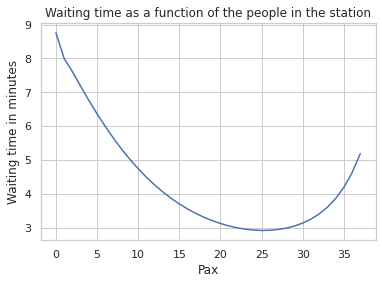

In [29]:
def waiting_time(pax):
    """Calculate the mean waiting time as a function of the pax in the platform."""
    posterior_x = get_posterior_x(pax)

    # Compute waiting times
    vx, vy = np.meshgrid(extended_time_range, extended_time_range)
    waiting_time = vx - vy

    vx, vy = np.meshgrid(augmented_posterior_z, posterior_x)
    joint_p = vx * vy

    posterior_y = pd.DataFrame({
        "waiting_time": waiting_time.ravel(),
        "joint_p": joint_p.ravel()
    }).groupby("waiting_time").joint_p.sum()

    # Only take into account positive values as negative ones mean that we lost
    # the train
    posterior_y = posterior_y[posterior_y.index >= 0]

    posterior_y /= posterior_y.sum()  # Normalize
    return np.sum(posterior_y.index.values * posterior_y.values)

waiting_time_series = pd.Series(
    [waiting_time(pax) for pax in range(38)]
)

_, ax = plt.subplots()
ax.set_title("Waiting time as a function of the people in the station")
ax.set_xlabel("Pax")
ax.set_ylabel("Waiting time in minutes")
waiting_time_series.plot()
waiting_time_series.idxmin()